# Forward Simulation of 2D VEP model at Source level

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import numba
from numba import jit

import matplotlib.pyplot as plt
from matplotlib import colors, cm

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [4]:
cwd = os.getcwd()
cwd

'/data/VEP_benchmark/VEP_Optimization_Benchmark'

In [5]:
Res_dir='data_output_files'

In [6]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

## Structural Connectivity and Gain Matrices

In [7]:
weights = np.loadtxt(os.path.join(cwd+"/ExperimentalData/connectivity", "weights.txt"))

In [8]:
# normalize Connectome
weights = weights/np.max(weights)
num_regions = len(weights)

In [9]:
weights.min(), weights.max()

(0.0, 1.0)

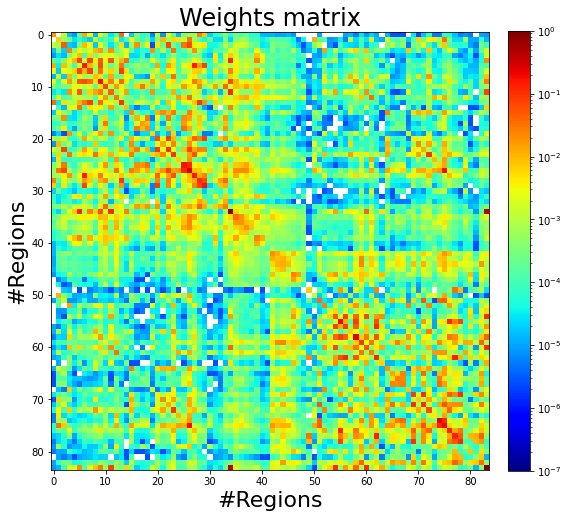

In [10]:
plt.figure(figsize=(8, 8))

norm = colors.LogNorm(1e-7, weights.max())
im = plt.imshow(weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Weights matrix', fontsize=24.0)
plt.ylabel('#Regions', fontsize=22.0)
plt.xlabel('#Regions', fontsize=22.0)
plt.tight_layout()
plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [11]:
# here we set the ground-truth

hz_val=-3.5 
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_idx = np.array([5, 11, 27],  dtype=np.int32)

In [12]:
nn=84

In [13]:
hz_idx=np.array(list(set(np.r_[0:nn])-set(ez_idx)-set(pz_idx)))

In [14]:
#Here, we increase manually the weights between EZ and PZ to get propagation:
weights[np.ix_(np.array([5,11]), ez_idx)] = 4.0
weights[np.ix_(np.array([27]), ez_idx)] = 1.0

In [15]:
# SC is given to simulator as fixed values (at the end we use this matrix to connect the nodes.) 
SC=weights
SC.shape

(84, 84)

### Simulator

In [16]:
@jit(nopython=False) 
def VEP2Dmodel(params, constants, init_conditions, SC, dt, ts):
    
    nt=ts.shape[0]
    nn=SC.shape[0]
    
    #parameters
    eta=params[0:nn]
    K=params[-1]
    
    # fixed parameters
    tau0, I1, sigma=constants[0], constants[1], constants[2]


    # simulation from initial point
    x = np.zeros((nn, nt))  # fast voltage
    z = np.zeros((nn, nt))  # slow voltage

    # initial conditions
    x_init, z_init=init_conditions[0], init_conditions[1]
    for i in range(0, nn):
          x[i, 0] = x_init
          z[i, 0] = z_init
    

    # integrate ODE
    for t in range(0, nt-1):
        for i in range(0, nn):
            gx = 0;
            for j in range(0, nn):
                    gx = gx + SC[i, j]*(x[j, t] - x[i, t]);
            dx = 1.0 -  np.power(x[i, t], 3) - 2.0*np.power(x[i, t], 2) - z[i, t] + I1;
            dz = (1./tau0)*(4.*(x[i, t] - eta[i]) - z[i, t] - K*gx);
            x[i, t+1] = x[i, t] + dt*dx + np.sqrt(dt) * sigma * np.random.randn() 
            z[i, t+1] = z[i, t] + dt*dz + np.sqrt(dt) * sigma * np.random.randn()  
  
    
    return np.concatenate((x.reshape(-1) , z.reshape(-1) )) 

### A simulations for  sanity check

In [17]:
T = 14.0
dt=0.1
ts = np.arange(0, T + dt, dt)

In [18]:
nt=ts.shape[0]
nt

141

In [19]:
nn=SC.shape[0]
nn

84

In [20]:
tau0=10.
I1=3.1    
sigma=0. # we assume ODE so no noise in the system
constants = np.array([tau0, I1, sigma])

In [21]:
x_init=-2.5
z_init=3.5
init_conditions = np.array([x_init, z_init])

In [22]:
eta_true = np.ones(nn)*hz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [23]:
K_true=1. # global copuling parameters

In [24]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [25]:
start_time = time.time()
Sim = VEP2Dmodel(params_true, constants, init_conditions, SC, dt, ts)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 1.0080654621124268


In [26]:
start_time = time.time()
Sim_true = VEP2Dmodel(params_true, constants, init_conditions, SC, dt, ts)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 0.0031881332397460938


In [27]:
Sim_true.shape

(23688,)

In [28]:
# Sim_source=Sim.reshape(nn, int(Sim.shape[0]/(nn)))
# Sim_source.shape

# X=Sim_source[:,0:nt]
# Z=Sim_source[:,nt:2*nt]

In [29]:
X_true=Sim_true[0:nn*nt].reshape(nn, nt)
Z_true=Sim_true[nn*nt:2*nn*nt].reshape(nn, nt)

In [30]:
X_true.shape, Z_true.shape

((84, 141), (84, 141))

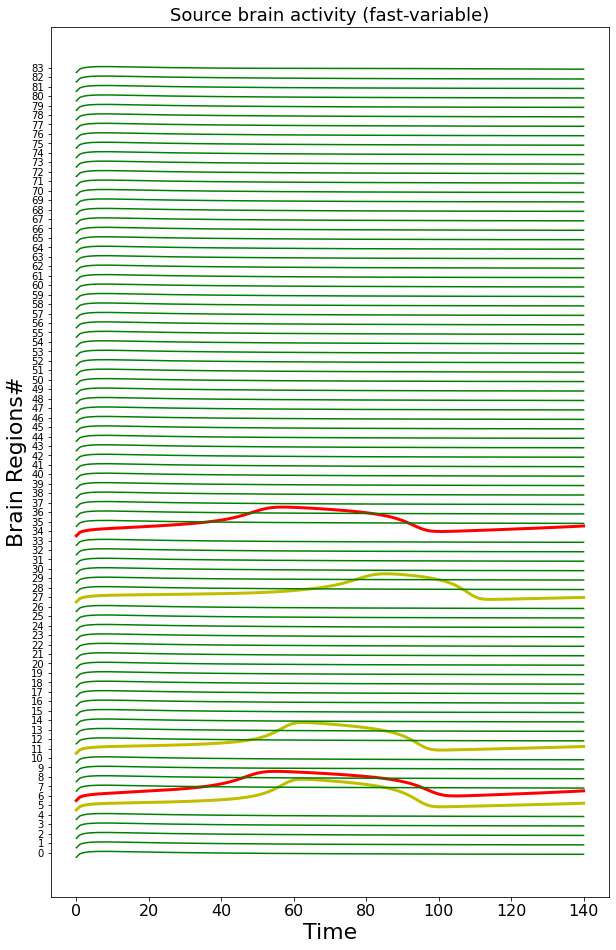

In [31]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X_true[i,:]+i, 'r', lw=3)
    elif i in pz_idx:
          plt.plot(X_true[i,:]+i, 'y', lw=3)
    else:  
          plt.plot(X_true[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity (fast-variable)",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)
plt.show()

# Objective function

In [32]:
X_true.shape

(84, 141)

In [33]:
X_obs=X_true

In [34]:
params_true=np.append(eta_true, K_true)
params_true

array([-3.5, -3.5, -3.5, -3.5, -3.5, -2.4, -1.6, -3.5, -3.5, -3.5, -3.5,
       -2.4, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -2.4, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -1.6, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,  1. ])

In [35]:
def RMSE(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean()) 

### Optimizing only EZ/PZ/K

In [36]:
def black_box_function(x):
    eta_propsal=eta_true
    eta_propsal[ez_idx[0]]=x[0]
    eta_propsal[ez_idx[1]]=x[1]
    eta_propsal[pz_idx[0]]=x[2]
    eta_propsal[pz_idx[1]]=x[3]
    eta_propsal[pz_idx[2]]=x[4]
    K_propsal=x[5]
    
    params_val=np.append(eta_propsal, K_propsal)
    Sim =VEP2Dmodel(params_val, constants, init_conditions, SC, dt, ts)
    X_model=Sim[0:nn*nt].reshape(nn, nt)

    return np.sqrt(np.sum((X_model-X_obs)**2))

### DE

In [37]:
bounds=[(-4, 0), (-4, 0), (-4, 0), (-4, 0), (-4, 0), (0, 2)]

In [38]:
from scipy.optimize import differential_evolution

In [39]:
val=[]
cost_val=[]
def callback(xk, convergence):
        val.append(convergence)
        cost_val.append(black_box_function(xk))
        #print(xk, convergence, cost_val)

In [40]:
%%time

result = differential_evolution(black_box_function, bounds,  popsize=10,  maxiter=100, disp=False,  callback=callback )

CPU times: user 21.5 s, sys: 0 ns, total: 21.5 s
Wall time: 21.6 s


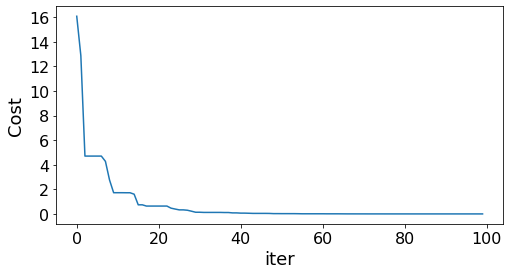

In [41]:
plt.figure(figsize=(8,4))
plt.plot(cost_val)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [42]:
result.x, result.fun

(array([-1.5999988 , -1.60000251, -2.39999009, -2.40000797, -2.40000087,
         1.00000112]),
 9.662104890881167e-05)

In [43]:
idx_=[ez_idx[0], ez_idx[1], pz_idx[0], pz_idx[1], pz_idx[2], nn]
idx_

[6, 34, 5, 11, 27, 84]

In [44]:
params_est=np.zeros(nn+1)
params_est[0:nn+1]=params_true
params_est[idx_]=result.x

RMSE(params_est, params_true)

1.4201105493359132e-06

In [45]:
Sim_est = VEP2Dmodel(params_est, constants, init_conditions, SC, dt, ts)

X_est=Sim_est[0:nn*nt].reshape(nn, nt)
Z_est=Sim_est[nn*nt:2*nn*nt].reshape(nn, nt)

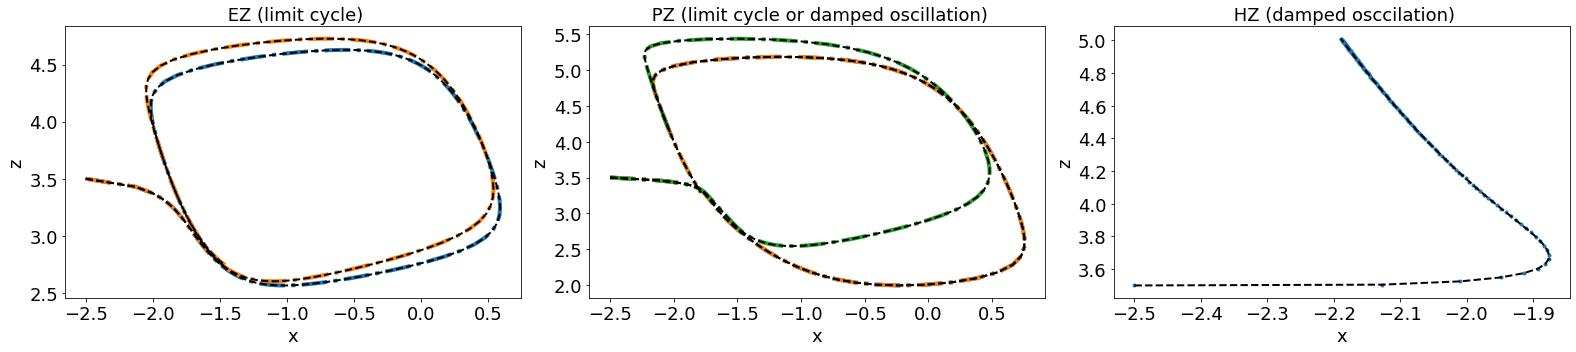

In [46]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true[ez_idx].T, Z_true[ez_idx].T, '-.', lw=4);
plt.plot(X_est[ez_idx].T, Z_est[ez_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" EZ (limit cycle)",fontsize=18)

plt.subplot(132)
plt.plot(X_true[pz_idx].T, Z_true[pz_idx].T, '-.', lw=4);
plt.plot(X_est[pz_idx].T, Z_est[pz_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" PZ (limit cycle or damped oscillation)",fontsize=18)


plt.subplot(133)
plt.plot(X_true[1].T, Z_true[1].T, '.', lw=4);
plt.plot(X_est[1].T, Z_est[1].T, lw=2, color='k',linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" HZ (damped osccilation)",fontsize=18)

plt.tight_layout()
plt.savefig("FittedVEP_limitcycle_EZPZ_DE.png", dpi=800)
plt.savefig("FittedVEP_limitcycle_EZPZ_DE.eps", dpi=800)
plt.show()

### PSO

In [47]:
from pyswarm import pso

In [48]:
lb = [-4, -4, -4, -4, -4, 0]
ub = [0, 0, 0, 0, 0, 2]

In [49]:
%%time

xopt, fopt = pso(black_box_function, lb, ub, swarmsize=100, maxiter=1000)

Stopping search: Swarm best position change less than 1e-08
CPU times: user 21.2 s, sys: 0 ns, total: 21.2 s
Wall time: 21.2 s


In [50]:
xopt, fopt

(array([-1.6       , -1.6       , -2.39999999, -2.39999999, -2.4       ,
         1.        ]),
 8.985281736674264e-08)

### PSO

In [51]:
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO

In [52]:
n_particles=10

In [53]:
def black_box_function_pso(x):
    eta_propsal=(eta_true.reshape(1,-1))*ones((n_particles,1))

    eta_propsal[:,ez_idx[0]]=x[:, 0]
    eta_propsal[:,ez_idx[1]]=x[:, 1]
    eta_propsal[:,pz_idx[0]]=x[:, 2]
    eta_propsal[:,pz_idx[1]]=x[:, 3]
    eta_propsal[:,pz_idx[2]]=x[:, 4]
    K_propsal=x[:, 5].reshape(-1,1)
    params_val=np.zeros((n_particles,nn+1))
    params_val= np.hstack([eta_propsal, K_propsal])
    Sim=zeros((n_particles,2*nn*nt))
    RMSE=zeros((n_particles))
    for i in range(n_particles):
        Sim[i,0:2*nn*nt] =VEP2Dmodel(params_val[i,0:nn+1], constants, init_conditions, SC, dt, ts)
        X_model=Sim[i,0:nn*nt].reshape(nn, nt)
        RMSE[i]=np.sqrt(np.sum((X_model-X_obs)**2))
    return RMSE

In [54]:
x_min = array([-4, -4, -4, -4, -4, 0])
x_max = array([0, 0, 0, 0, 0, 2])
bounds = (x_min, x_max)

In [55]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=6, options=options, bounds=bounds)

In [56]:
%%time

cost, pos = optimizer.optimize(black_box_function_pso, iters=500)

2023-01-20 15:48:10,712 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.00151
2023-01-20 15:48:28,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0015122482658638308, best pos: [-1.60001791 -1.60001438 -2.39988233 -2.39971042 -2.39996895  0.99997205]


CPU times: user 18.2 s, sys: 228 ms, total: 18.4 s
Wall time: 18.1 s


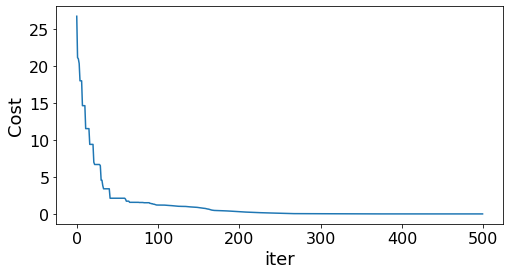

In [57]:
plt.figure(figsize=(8,4))
plt.plot(optimizer.cost_history)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Bayesian Optimization

In [58]:
from matplotlib import gridspec
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((0, 2))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((0, 2))
    acq.set_ylim((-25, np.max(utility) + 1.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [59]:
def black_box_function_BO(eta_ez1, eta_ez2, eta_pz1, eta_pz2, eta_pz3, K):
    
    eta_propsal=eta_true
    eta_propsal[ez_idx[0]]=eta_ez1
    eta_propsal[ez_idx[1]]=eta_ez2
    eta_propsal[pz_idx[0]]=eta_pz1
    eta_propsal[pz_idx[1]]=eta_pz2
    eta_propsal[pz_idx[2]]=eta_pz3

    K_propsal=K
    
    params_val=np.append(eta_propsal, K_propsal)
    Sim =VEP2Dmodel(params_val, constants, init_conditions, SC, dt, ts)
    X_model=Sim[0:nn*nt].reshape(nn, nt)

    return -1*np.sqrt(np.sum((X_model-X_obs)**2))

In [60]:
pbounds = {'eta_ez1': (-4, 0) , 'eta_ez2': (-4, 0) , 'eta_pz1': (-4, 0) , 'eta_pz2': (-4, 0) , 'eta_pz3': (-4, 0) , 'K': (0, 2)}
pbounds

{'eta_ez1': (-4, 0),
 'eta_ez2': (-4, 0),
 'eta_pz1': (-4, 0),
 'eta_pz2': (-4, 0),
 'eta_pz3': (-4, 0),
 'K': (0, 2)}

In [61]:
from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(
    f=black_box_function_BO,
    pbounds=pbounds,
    random_state=1,
)

In [62]:
%%time

optimizer.maximize(init_points=50,n_iter=50, kappa=100)


|   iter    |  target   |     K     |  eta_ez1  |  eta_ez2  |  eta_pz1  |  eta_pz2  |  eta_pz3  |
-------------------------------------------------------------------------------------------------
| 1         | -27.66    | 0.834     | -1.119    | -4.0      | -2.791    | -3.413    | -3.631    |
| 2         | -29.18    | 0.3725    | -2.618    | -2.413    | -1.845    | -2.323    | -1.259    |
| 3         | -31.26    | 0.4089    | -0.4875   | -3.89     | -1.318    | -2.331    | -1.765    |
| 4         | -34.85    | 0.2808    | -3.208    | -0.797    | -0.127    | -2.746    | -1.231    |
| 5         | -35.97    | 1.753     | -0.4216   | -3.66     | -3.844    | -3.321    | -0.4874   |
| 6         | -28.65    | 0.1967    | -2.316    | -0.1684   | -1.867    | -1.232    | -2.738    |
| 7         | -38.58    | 1.373     | -0.6615   | -3.927    | -0.9994   | -0.04456  | -1.007    |
| 8         | -30.69    | 0.5609    | -0.8429   | -3.587    | -2.208    | -0.3656   | -2.826    |
| 9         | -33.59

| 51        | -7.099    | 1.379     | -1.525    | -1.538    | -2.607    | -3.392    | -2.526    |
| 52        | -15.68    | 1.69      | -1.498    | -1.928    | -2.338    | -3.562    | -2.389    |
| 53        | -12.56    | 1.445     | -1.552    | -1.091    | -2.578    | -3.09     | -2.721    |
| 54        | -17.3     | 1.137     | -1.825    | -1.731    | -2.962    | -3.219    | -2.588    |
| 55        | -8.457    | 1.285     | -1.63     | -1.296    | -2.376    | -3.731    | -2.661    |
| 56        | -14.47    | 1.556     | -1.624    | -1.178    | -2.647    | -3.599    | -2.184    |
| 57        | -7.958    | 1.044     | -1.309    | -1.487    | -2.182    | -3.32     | -2.551    |
| 58        | -12.05    | 1.299     | -1.268    | -1.599    | -2.326    | -3.455    | -3.075    |
| 59        | -9.75     | 1.217     | -1.814    | -1.506    | -2.113    | -3.271    | -2.61     |
| 60        | -8.488    | 0.9512    | -1.499    | -1.678    | -2.389    | -3.674    | -2.531    |
| 61        | -7.203

In [63]:
optimizer.maximize(init_points=50,n_iter=50, xi=0.1)

|   iter    |  target   |     K     |  eta_ez1  |  eta_ez2  |  eta_pz1  |  eta_pz2  |  eta_pz3  |
-------------------------------------------------------------------------------------------------
| 101       | -28.46    | 1.624     | -0.5002   | -1.246    | -1.722    | -3.356    | -2.132    |
| 102       | -31.97    | 0.6903    | -3.1      | -1.63     | -2.751    | -0.3348   | -0.3615   |
| 103       | -32.61    | 0.5142    | -3.556    | -3.228    | -2.002    | -1.086    | -3.167    |
| 104       | -31.12    | 0.4961    | -0.5933   | -2.337    | -1.533    | -3.065    | -3.592    |
| 105       | -29.81    | 1.032     | -2.091    | -3.389    | -1.513    | -1.824    | -1.383    |
| 106       | -28.12    | 0.2891    | -0.9939   | -3.112    | -1.923    | -0.8588   | -3.911    |
| 107       | -40.48    | 0.6487    | -0.5083   | -0.6212   | -1.846    | -0.5336   | -0.2008   |
| 108       | -36.36    | 1.653     | -0.5835   | -3.605    | -1.395    | -1.186    | -1.559    |
| 109       | -28.34

| 151       | -16.9     | 1.273     | -1.902    | -1.615    | -2.268    | -4.0      | -2.487    |
| 152       | -10.54    | 2.0       | -1.642    | -1.456    | -2.604    | -3.402    | -2.831    |
| 153       | -17.61    | 2.0       | -1.308    | -1.131    | -2.146    | -4.0      | -3.483    |
| 154       | -15.21    | 0.2668    | -1.618    | -1.49     | -2.401    | -1.477    | -2.251    |
| 155       | -28.73    | 0.0       | -1.029    | -1.074    | -2.688    | -1.408    | -2.849    |
| 156       | -4.416    | 0.8267    | -1.564    | -1.556    | -2.272    | -3.114    | -2.303    |
| 157       | -8.02     | 0.6959    | -1.675    | -1.519    | -2.237    | -2.586    | -1.951    |
| 158       | -4.576    | 0.9022    | -1.664    | -1.492    | -2.04     | -2.834    | -2.262    |
| 159       | -14.49    | 0.7389    | -2.01     | -1.482    | -1.806    | -2.165    | -2.293    |
| 160       | -4.076    | 0.9727    | -1.692    | -1.465    | -2.315    | -2.791    | -2.312    |
| 161       | -10.11

In [64]:
print(optimizer.max)

{'target': -3.4511387720288993, 'params': {'K': 0.9842887541916596, 'eta_ez1': -1.6280653390043605, 'eta_ez2': -1.6127352677610043, 'eta_pz1': -2.240518722557527, 'eta_pz2': -2.951935599378846, 'eta_pz3': -2.3559769468224654}}


In [65]:
params_opt=optimizer.max['params']
params_opt

{'K': 0.9842887541916596,
 'eta_ez1': -1.6280653390043605,
 'eta_ez2': -1.6127352677610043,
 'eta_pz1': -2.240518722557527,
 'eta_pz2': -2.951935599378846,
 'eta_pz3': -2.3559769468224654}

In [66]:
params_est=np.zeros(nn+1)

params_est[0:nn+1]=params_true

params_est[ez_idx[0]]=params_opt['eta_ez1']
params_est[ez_idx[1]]=params_opt['eta_ez2']

params_est[pz_idx[0]]=params_opt['eta_pz1']
params_est[pz_idx[1]]=params_opt['eta_pz2']
params_est[pz_idx[2]]=params_opt['eta_pz3']

params_est[-1]=params_opt['K']

In [67]:
RMSE(params_est, params_true)

0.06261008248730113

In [68]:
Sim_est = VEP2Dmodel(params_est, constants, init_conditions, SC, dt, ts)

X_est=Sim_est[0:nn*nt].reshape(nn, nt)
Z_est=Sim_est[nn*nt:2*nn*nt].reshape(nn, nt)

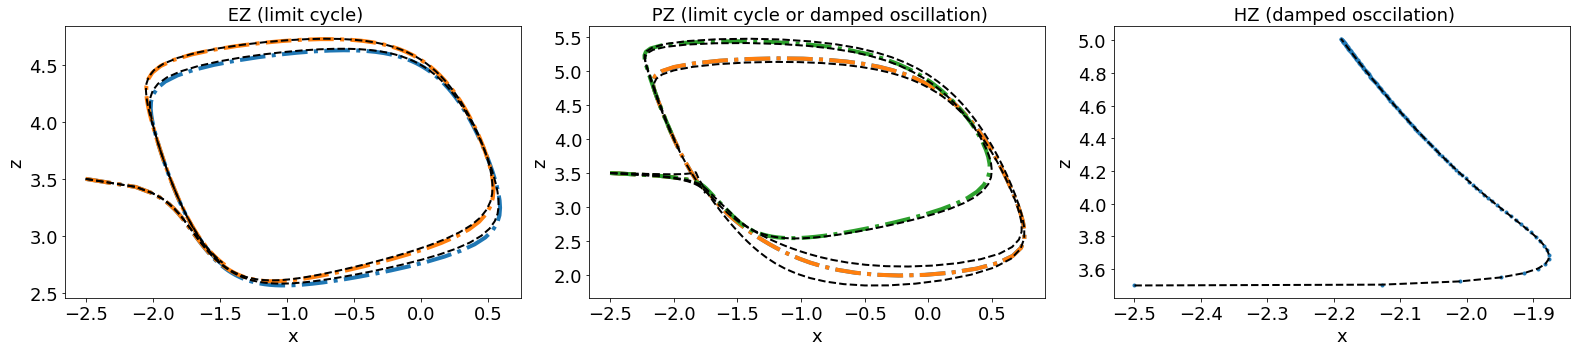

In [69]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true[ez_idx].T, Z_true[ez_idx].T, '-.', lw=4);
plt.plot(X_est[ez_idx].T, Z_est[ez_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" EZ (limit cycle)",fontsize=18)

plt.subplot(132)
plt.plot(X_true[pz_idx].T, Z_true[pz_idx].T, '-.', lw=4);
plt.plot(X_est[pz_idx].T, Z_est[pz_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" PZ (limit cycle or damped oscillation)",fontsize=18)


plt.subplot(133)
plt.plot(X_true[1].T, Z_true[1].T, '.', lw=4);
plt.plot(X_est[1].T, Z_est[1].T, lw=2, color='k',linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" HZ (damped osccilation)",fontsize=18)

plt.tight_layout()
plt.savefig("FittedVEP_limitcycle_EZPZ_Bayesopt.png", dpi=800)
plt.savefig("FittedVEP_limitcycle_EZPZ_Bayesopt.eps", dpi=800)
plt.show()

### Optimization on whole-brain parameters

In [70]:
def f(x):
    eta_propsal=x[0:nn]
    K_propsal=x[-1]
    params_val=np.append(eta_propsal, K_propsal)
    Sim =VEP2Dmodel(params_val, constants, init_conditions, SC, dt, ts)
    X_model=Sim[0:nn*nt].reshape(nn, nt)

    return np.sqrt(np.sum((X_model-X_obs)**2))

### DE

In [71]:
bounds_= [(-4,0) for _ in range(nn)]
bounds_K=[(0,2)]
bounds_.extend(bounds_K)
bounds=bounds_

In [72]:
val=[]
cost_val=[]
def callback(xk, convergence):
        val.append(convergence)
        cost_val.append(f(xk))
        #print(xk, convergence, cost_val)

In [73]:
%%time

result = differential_evolution(f, bounds,  popsize=20,  maxiter=1000, disp=False,  callback=callback )

CPU times: user 1h 29min 41s, sys: 224 ms, total: 1h 29min 41s
Wall time: 1h 29min 40s


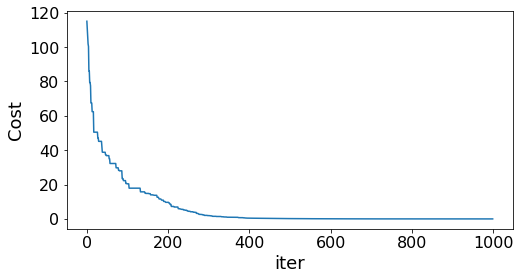

In [74]:
plt.figure(figsize=(8,4))
plt.plot(cost_val)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [75]:
result.x, result.fun

(array([-3.50000001, -3.5       , -3.5       , -3.5       , -3.50000001,
        -2.4       , -1.6       , -3.50000001, -3.5       , -3.5       ,
        -3.5       , -2.39999998, -3.50000001, -3.50000001, -3.50000001,
        -3.50000001, -3.5       , -3.50000001, -3.5       , -3.5       ,
        -3.50000001, -3.5       , -3.50000001, -3.50000001, -3.50000001,
        -3.50000001, -3.5       , -2.40000001, -3.50000002, -3.50000002,
        -3.50000001, -3.5       , -3.5       , -3.50000001, -1.60000001,
        -3.50000001, -3.50000001, -3.50000001, -3.5       , -3.5       ,
        -3.5       , -3.50000001, -3.5       , -3.50000001, -3.50000001,
        -3.5       , -3.50000001, -3.50000001, -3.50000001, -3.50000001,
        -3.50000001, -3.50000001, -3.50000001, -3.50000001, -3.50000001,
        -3.5       , -3.5       , -3.50000001, -3.50000001, -3.5       ,
        -3.50000001, -3.50000001, -3.5       , -3.50000001, -3.50000001,
        -3.50000001, -3.5       , -3.5       , -3.5

In [76]:
params_est=np.zeros(nn+1)
params_est[0:nn+1]=result.x

RMSE(params_est, params_true)

6.6191894922136434e-09

In [77]:
Sim_est = VEP2Dmodel(params_est, constants, init_conditions, SC, dt, ts)

X_est=Sim_est[0:nn*nt].reshape(nn, nt)
Z_est=Sim_est[nn*nt:2*nn*nt].reshape(nn, nt)

In [78]:
nodes=np.r_[0:nn]

2023-01-20 17:19:16,083 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-01-20 17:19:16,085 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-01-20 17:19:16,086 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-01-20 17:19:16,087 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-01-20 17:19:16,088 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2023-01-20 17:19:16,088 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support t

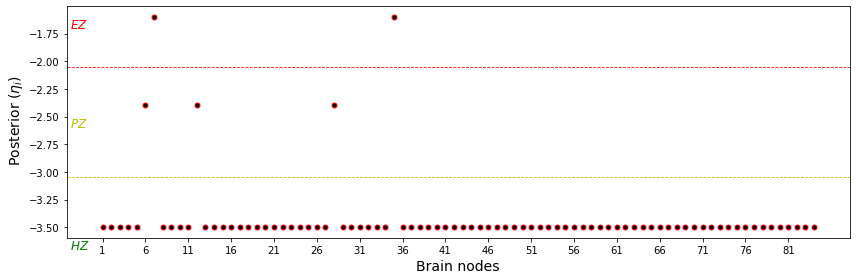

In [79]:
plt.figure(figsize=(12, 4))
plt.plot(nodes+1, params_est[0:nn] ,'o', color='r', alpha=0.9, markersize=5)

plt.plot(ez_idx+1, ez_val*np.ones((len(ez_idx))) ,'o', color='k', alpha=0.9, markersize=3)
plt.plot(pz_idx+1, pz_val*np.ones((len(pz_idx))) ,'o', color='k', alpha=0.9, markersize=3)
plt.plot(hz_idx+1, hz_val*np.ones((len(hz_idx))),'o' , color='k', alpha=0.9, markersize=3)
plt.axhline(y=eta_c, linewidth=.8, color = 'r', linestyle='--')
plt.axhline(y=eta_c-delta_eta, linewidth=.8, color = 'y', linestyle='--')
text(-2.85, -1.7, "$EZ$", size=12, color = 'r')
text(-2.85, -2.6, "$PZ$", size=12, color = 'y')
text(-2.85, -3.7, "$HZ$", size=12, color = 'g')
#plt.xticks(np.r_[1:len(nodes)+1], np.r_[1:len(nodes)+1], rotation=90, fontsize=8)  
plt.xticks(np.arange(1,len(nodes)+1, step=5),np.arange(1, len(nodes)+1, step=5), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=14);  
plt.xlabel('Brain nodes', fontsize=14); 
plt.tight_layout()

plt.savefig("FittedVEP_violonplot_DE.png", dpi=800)
plt.savefig("FittedVEP_violonplot_DE.eps", dpi=800)
plt.show()

### PSO

In [80]:
from pyswarm import pso

In [81]:
lb= [-4] * nn
lb.extend([0])

ub= [0] * nn
ub.extend([2])

In [82]:
%%time

xopt, fopt = pso(black_box_function, lb, ub, swarmsize=100, maxiter=1000)

Stopping search: Swarm best position change less than 1e-08
CPU times: user 50.2 s, sys: 8 ms, total: 50.2 s
Wall time: 50.2 s


In [83]:
xopt, fopt

(array([-1.66282727, -1.66402548, -2.37530849, -1.78335081, -1.93210255,
         0.        , -1.07568302, -1.21882892, -3.39132446, -3.22101404,
         0.        , -0.65596224, -3.64098336, -0.9462492 , -2.58507639,
        -2.47635294, -1.64978271, -0.11093927, -0.97329359, -2.20996864,
        -1.84310313, -1.73423073, -0.61748134, -3.15580874, -1.09163344,
        -2.68341705, -1.10224551, -3.56425189, -2.01720042, -0.711601  ,
        -0.59023792, -3.9070765 , -3.98708816, -2.59843692, -0.06189438,
        -0.69682496, -2.91657285, -3.47178627, -3.6018851 , -3.76408747,
        -1.9034008 , -3.46203127, -3.24232517, -2.89962689, -1.67670847,
        -0.05520572, -0.32026152, -3.56372219, -2.5731727 , -1.17087473,
        -2.86452943, -1.80879707, -1.3573122 , -1.75777818, -0.86232671,
        -3.36070583, -3.88923842, -0.96657517, -1.14372201, -2.52028223,
        -1.1715858 , -2.39970583, -1.04267101, -3.58151726, -0.74296537,
        -1.69422312, -0.76339424, -2.2923374 , -0.0

In [84]:
RMSE(xopt, params_true)

1.9195802583593826

### PSO

In [85]:
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO

In [86]:
n_particles=100

In [87]:
def black_box_function_pso(x):
    eta_propsal=(zeros(nn).reshape(1,-1))*ones((n_particles,1))
    eta_propsal[:,0:nn-1]=x[:, 0:nn-1]
    K_propsal=x[:, nn].reshape(-1,1)
    
    params_val=np.zeros((n_particles,nn+1))
    params_val= np.hstack([eta_propsal, K_propsal])
    Sim=zeros((n_particles,2*nn*nt))
    RMSE=zeros((n_particles))
    for i in range(n_particles):
        Sim[i,0:2*nn*nt] =VEP2Dmodel(params_val[i,0:nn+1], constants, init_conditions, SC, dt, ts)
        X_model=Sim[i,0:nn*nt].reshape(nn, nt)
        RMSE[i]=np.sqrt(np.sum((X_model-X_obs)**2))
    return RMSE

In [88]:
x_min = np.repeat(-4, nn)
x_max =np.repeat(0, nn)

bounds = (np.append(x_min,  0) , np.append(x_max,  2))

In [89]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=nn+1, options=options, bounds=bounds)

In [90]:
%%time

cost, pos = optimizer.optimize(black_box_function_pso, iters=1000)

2023-01-20 17:20:06,544 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=51.7
2023-01-20 17:25:25,246 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 51.665481490686325, best pos: [-3.14846086 -2.81253251 -2.99073167 -3.06351046 -2.81214029 -1.64801524
 -1.70219816 -2.9045471  -2.48110416 -3.25977736 -2.02157894 -2.83153768
 -2.8120136  -2.60314225 -2.3801344  -2.85255815 -3.16186299 -2.10461946
 -3.41940921 -2.65068187 -3.02225323 -2.47216235 -2.28074401 -2.38419039
 -2.44534461 -1.30483439 -2.35635485 -2.41357087 -2.84325593 -2.55733336
 -2.59362205 -2.44768974 -2.11391205 -2.72731357 -2.45183514 -3.06351649
 -3.15894176 -2.53009932 -3.10964433 -3.21746075 -2.72485967 -2.64727111
 -3.21925458 -3.20942099 -2.09044752 -2.60495495 -2.51634689 -3.01322928
 -3.17052392 -2.28412973 -2.5482941  -3.24370096 -2.02426938 -2.63669562
 -2.41056563 -2.201

CPU times: user 5min 18s, sys: 672 ms, total: 5min 19s
Wall time: 5min 18s


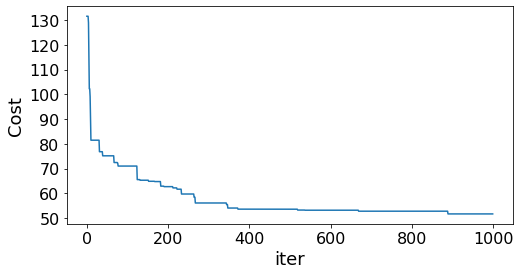

In [91]:
plt.figure(figsize=(8,4))
plt.plot(optimizer.cost_history)
plt.ylabel('Cost', fontsize=18); 
plt.xlabel('iter', fontsize=18); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Bayesian Optimization

In [92]:
bounds_eta = np.array([[-4*ones(nn), .0*ones(nn)]]).T[:,:,0]
bounds_K = np.array([[0, 2]])
bounds_eta.shape, bounds_K.shape

((84, 2), (1, 2))

In [93]:
bounds=np.vstack([bounds_eta, bounds_K])
bounds.shape

(85, 2)

In [94]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  bounds,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=1000,         # the number of evaluations of f
                  n_random_starts=1000,  # the number of random initialization points
                  noise=0.0,       # the noise level (optional)
                  random_state=1234)   # the random seed


In [95]:
params_est=res.x

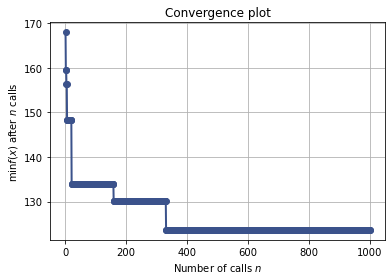

In [96]:
from skopt.plots import plot_convergence
plot_convergence(res);

In [97]:
Sim_est = VEP2Dmodel(params_est, constants, init_conditions, SC, dt, ts)

X_est=Sim_est[0:nn*nt].reshape(nn, nt)
Z_est=Sim_est[nn*nt:2*nn*nt].reshape(nn, nt)

In [98]:
RMSE(np.asarray(params_est), np.asarray(params_true))

1.5028886702964246

In [99]:
nodes=np.r_[0:nn]

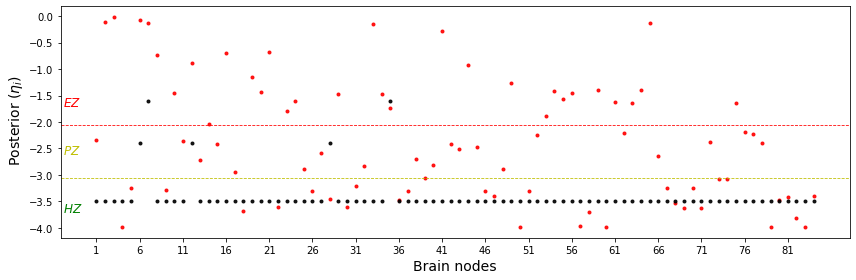

In [100]:
plt.figure(figsize=(12, 4))
plt.plot(nodes+1, params_est[0:nn] ,'o', color='r', alpha=0.9, markersize=3)

plt.plot(ez_idx+1, ez_val*np.ones((len(ez_idx))) ,'o', color='k', alpha=0.9, markersize=3)
plt.plot(pz_idx+1, pz_val*np.ones((len(pz_idx))) ,'o', color='k', alpha=0.9, markersize=3)
plt.plot(hz_idx+1, hz_val*np.ones((len(hz_idx))),'o' , color='k', alpha=0.9, markersize=3)
plt.axhline(y=eta_c, linewidth=.8, color = 'r', linestyle='--')
plt.axhline(y=eta_c-delta_eta, linewidth=.8, color = 'y', linestyle='--')
text(-2.85, -1.7, "$EZ$", size=12, color = 'r')
text(-2.85, -2.6, "$PZ$", size=12, color = 'y')
text(-2.85, -3.7, "$HZ$", size=12, color = 'g')
#plt.xticks(np.r_[1:len(nodes)+1], np.r_[1:len(nodes)+1], rotation=90, fontsize=8)  
plt.xticks(np.arange(1,len(nodes)+1, step=5),np.arange(1, len(nodes)+1, step=5), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=14);  
plt.xlabel('Brain nodes', fontsize=14); 
plt.tight_layout()

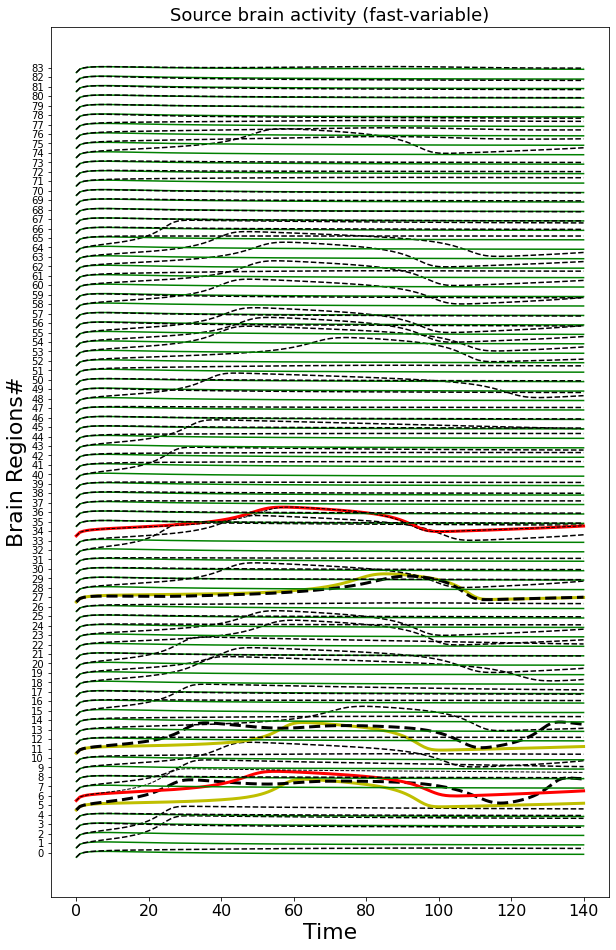

In [101]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X_true[i,:]+i, 'r', lw=3)
          plt.plot(X_est[i,:]+i, 'k--', lw=1)
    elif i in pz_idx:
          plt.plot(X_true[i,:]+i, 'y', lw=3)
          plt.plot(X_est[i,:]+i, 'k--', lw=3)
    else:  
          plt.plot(X_true[i,:]+i, 'g')
          plt.plot(X_est[i,:]+i, 'k--')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.xticks(fontsize=16)
plt.title("Source brain activity (fast-variable)",fontsize=18)
plt.xlabel('Time',fontsize=22)
plt.ylabel('Brain Regions#',fontsize=22)

plt.savefig("FittedVEP_Bayesopt.png", dpi=800)
plt.savefig("FittedVEP_Bayesopt.eps", dpi=800)

plt.show()

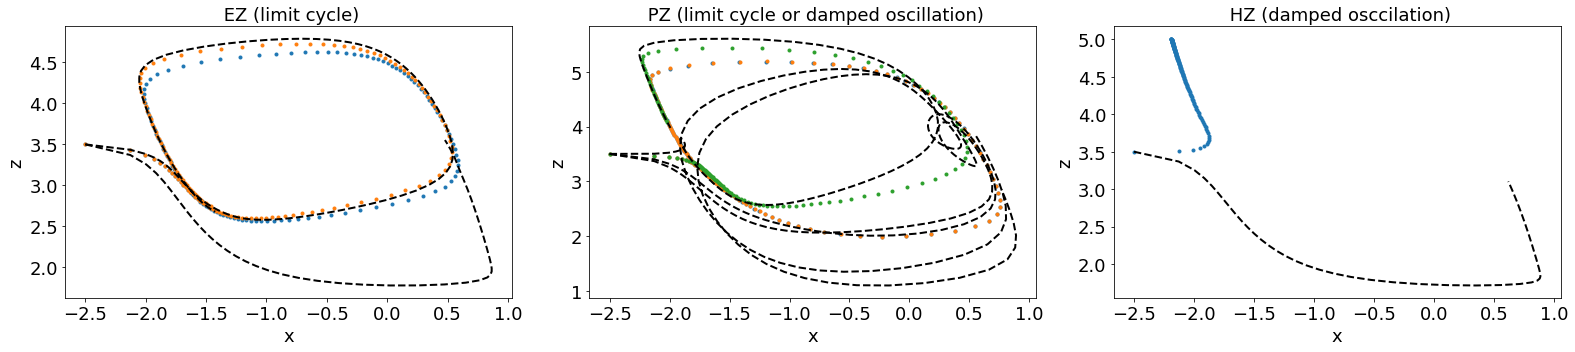

In [102]:
plt.figure(figsize=(22,5))
plt.subplot(131)
plt.plot(X_true[ez_idx].T, Z_true[ez_idx].T, '.', lw=4);
plt.plot(X_est[ez_idx].T, Z_est[ez_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" EZ (limit cycle)",fontsize=18)

plt.subplot(132)
plt.plot(X_true[pz_idx].T, Z_true[pz_idx].T, '.', lw=4);
plt.plot(X_est[pz_idx].T, Z_est[pz_idx].T, lw=2, color='k', linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" PZ (limit cycle or damped oscillation)",fontsize=18)


plt.subplot(133)
plt.plot(X_true[1].T, Z_true[1].T, '.', lw=4);
plt.plot(X_est[1].T, Z_est[1].T, lw=2, color='k',linestyle='dashed');

plt.xlabel('x',fontsize=18)
plt.ylabel('z',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(" HZ (damped osccilation)",fontsize=18)

plt.tight_layout()
plt.savefig("FittedVEP_limitcycle_Bayesopt.png", dpi=800)
plt.savefig("FittedVEP_limitcycle_Bayesopt.eps", dpi=800)
plt.show()